In [1]:
import pandas as pd
import numpy as np
#from funcs import *
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn import metrics
from matplotlib.pyplot import subplot
%matplotlib inline
from functools import reduce
import operator as op

### Import data

In [2]:
#data = pd.concat([X, y_recovered, y_deaths, y_recovered_smoothed, y_deaths_smoothed], axis=1)

In [3]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

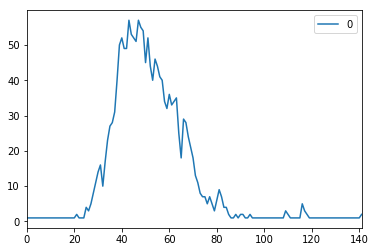

In [4]:
pd.DataFrame(y).plot()

In [17]:
# ----------------------------#
#        LOSS FUNCTIONS 
# ----------------------------#

def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

def mspe(y_test, y_pred):
    return np.mean(np.square((y_pred-y_test)/y_test))

def maape(y_test, y_pred):
    return np.mean(np.arctan(np.abs((y_pred-y_test)/y_test)))

def mae(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))



# ----------------------------------#
#        QUADRATIC OPTIMIZATION 
# ----------------------------------#
import cvxopt

def create_M(N):
    M = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i==0:
                if j == 0:
                    M[i,j]=1
                else:
                    M[i,j]=0
            elif (i==j):
                M[i,j]=1
            elif (j == (i-1)):
                M[i,j] = -1
            else:
                M[i,j]=0
    return M

def generate_G(index,N):
    """index: represents k^*, gamma_{k^*} is such that gamma_0 <= gamma_1 <= ...<= gamma_{k^*} >= ... >= gamma_N
    This function generates a matrix G such that either gamma_index or gamma_{index+1} is the maximum
    """ 
    #this constraint verifies the gaussian-like distribution of the gamma
    G = np.zeros((N,N))
    for i in range(0, index):
        for j in range(N):
            if (i==j):
                G[i,j] = 1
            elif (j == i+1):
                G[i,j] = -1
                
    for i in range(index, N):
        for j in range(N):
            if (i==j):
                G[i,j] = -1
            elif (j == i+1):
                G[i,j] = 1
    
    # we do not put any condition on idx_th element, and use this line to verify that all gammas are superior or
    # equal to zero
    #G[index,:] = 0
    #G[index, 0] = -1

    
    #this constraint verifies that -gamma_i <= 0 <=> gamma_i >= 0 forall i
   # for i in range(N, 2*N):
    #    for j in range(N):
     #       if (i==N+j):
      #          G[i,j]=-1
    return G

def generate_params(X_train, y_train,k,N,lambda_=10e-15):
    M = create_M(N)
    M_tilde = M.T @ M
    X_tilde = X_train.T @ X_train
    P = X_tilde + lambda_*(M_tilde)
    q = -X_train.T@y_train
    G = generate_G(k,N)
    h = np.zeros((N,1))
    for i in range(len(h)):
        h[i] = -0.0000001
    return P, q, G, h

def find_best_index(X_train, X_test, y_train, y_test, loss,N):
    """Returns index of maximum gamma that minimizes the mae loss"""
    loss = {}
    for k in range(N):
        P, q, G, h = generate_params(X_train, y_train, k, N, lambda_=10e-15)
        #print('P', P)
        #print('q', q)
        #print('G', G)
        #print('h', h)
        gammas = cvxopt_solve_qp(P,q, G, h)
        #print(X_test.shape)
        #print(gammas.shape)
        if not (gammas is None):
            y_pred = X_test@gammas
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            loss[k] = mae(y_test,y_pred)
        else:
            loss[k] = 999999999
    return min(loss, key=loss.get)


def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    cvxopt.solvers.options['show_progress'] = False
    P = .5 * (P + P.T)  # make sure P is symmetric
    #print('new P:', P)
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    #print('is optimal in solution status', 'optimal' not in sol['status'])
    #print('solution', sol['x'])
    #if 'optimal' not in sol['status']:
      #  return None
    #print(np.array(sol['x']).reshape((P.shape[1],)))
    return np.array(sol['x']).reshape((P.shape[1],))



def gauss_filter(x, K, parity='even'):

    # constant
    A = 2*K
    #upper bound of sum
    B = K
    if parity == 'odd':
        A += 1
        B += 1

    const = 1/(2**A)
    
    
    # range of k
    r_k = np.arange(-K,B+1)

    # x elements that will see their value change
    r_x = np.arange(K, len(x))
    
    len_x = len(x)
    
    # add K last elements mirrored to the x array
    x = np.append(x, x[-K:][::-1])
    x_filtered = []

    for i in range(len_x):
        if i not in r_x:
            x_filtered.append(x[i])
        else:
            # list on which we will save values to be summed to yield new x_tilde_t
            ls = []
            for k in r_k:
                #x_{t-k}
                comb = ncr(A, K+k)
                #print('i: ',i,'k: ',k)
                x_tk = x[i-k]
                #print(comb, x_tk, comb*x_tk)
                #print(ls)
                ls.append(int(comb*x_tk*const))
                #print(ls)
            x_filtered.append(np.sum(ls))
    return x_filtered


def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

def find_best_K(X, y, parity, with_validation=True, training_size=7, model='quadratic'):
    """Returns optimal K such that MAPE error is minimized for the gaussian smoothing"""
    X_new = np.zeros(X.shape)
    N = X.shape[1]
    Ks = np.arange(7,22)
    mapes = []
    dic0 = {}
    dic1 = {}


    for K in Ks:
        #print(K)
        for j in range(X.shape[1]):
            #print(j)
            X_new[:,j]= gauss_filter(X[:,j], K, parity)

        # train on first 10 days, then  predict 7 next / shiftt of seven until end on dataset
        
        splits = int(np.floor((X.shape[0] - training_size)/7))
    
        # list of the mape for a given split, this list is reinitialized for every K
        temp_mapes = []
        y_vals = []
        y_preds = []

        for i in range(splits):
            
            begin = 7*i
            end = training_size + 7*i

            X_tr = X_new[begin:end,:]
            y_tr = y[begin:end]

            X_te = X_new[end:end+7,:]
            y_te = y[end:end+7]


            index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
            P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
            gamma = cvxopt_solve_qp(P, q, G, h)
            y_pred = X_te@gamma
            y_pred[y_pred < 1 ] = 1
            y_pred = np.floor(y_pred)
            #y_vals.append(y_te)
            #y_preds.append(y_pred)
            #print('last y predicted: ', y_pred[-1])
            #print('last y test: ', y_te[-1])
            #print('mape: ', mape(y_te[-1], y_pred[-1]))

            temp_mapes.append(mae(y_te, y_pred))
            #print(mapes)
        #mean = np.mean(temp_mapes)
        #temp_mapes.append(mean)
        
        # for K, associate the list of mapes for each split
        dic0[K] = temp_mapes
        
        #append the mean mape for the given K
        mapes.append(np.mean(temp_mapes))
        
        # for K, associate the mean mape between all splits
        dic1[K] = np.mean(temp_mapes)
        
        #########
    
    # return K yielding smallest mean MAPE over all splits, dicionary of mean mape per K, dictionary of all
    # splits mapes per K
    #Ks[np.argmin(mapes)], dic1, dic0
    return Ks[np.argmin(mapes)], dic1[Ks[np.argmin(mapes)]]

#-------#

# SMOOTHING #

#---------#

def exponential_smoothing(x, rho, K):
    const = (1-rho)/(1-rho**(K+1))
    new_x = []
    
    # range of x
    r_x = np.arange(K, len(x)-K)

    # range of k
    r_k = np.arange(0,K)
    
    for i in range(len(x)):
        if i not in r_x:
            new_x.append(x[i])
        else:
            ls = []
            for k in r_k:
                ls.append(int(const*rho**k*x[i-k]))
            new_x.append(np.sum(ls))
                
    return new_x

def apply_smoothing(X, K, parity):

    new_X = np.zeros(X.shape)

    for j in range(X.shape[1]):
        new_X[:,j] = gauss_filter(X[:,j], K, parity=parity)
        
    
    return new_X

In [18]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [20]:
from tqdm import tqdm

training_poss = np.arange(3, 50)
loss_even = []
loss_odd = []
for tr in tqdm(training_poss):
    loss_even.append(find_best_K(X, y, 'even', training_size=tr)[1])
    loss_odd.append(find_best_K(X, y, 'odd', training_size=tr)[1])




100%|██████████| 47/47 [59:18<00:00, 75.57s/it]

(0.6999999999999997, 51.3, 1.873973395026027, 5.613591671486409)

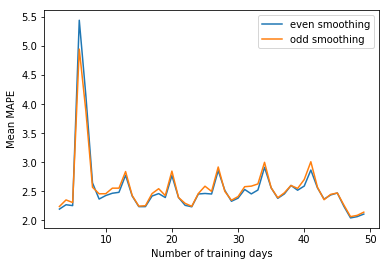

In [21]:
x_data = training_poss
y_data0 = loss_even
y_data1 = loss_odd           

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data0, label='even smoothing')
ax.plot(x_data, y_data1, label='odd smoothing')
plt.legend()
#plt.title('Mean MAPE loss based on \n the number of training days')

#ax.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
ax.set_xlabel('Number of training days')
ax.set_ylabel('Mean MAPE')

#plt.axvline(x=tr)
#min_ = 'K= ' + str(tr)
#
#ax.annotate(min_, xy=(tr, min(losses[idx])+2))
ax.axis()

In [22]:
minimums = [np.min(loss_even), np.min(loss_odd)]
losses = [loss_even, loss_odd]
idx = np.argmin(minimums) #if 0 even if 1 odd
tr = training_poss[np.argmin(losses[idx])]
parity = ''
if idx == 0:
    K = find_best_K(X, y, parity='even',training_size = tr)[0]
    X = apply_smoothing(X, K, 'even') 
    parity = 'even'
else:
    K = find_best_K(X, y, parity='odd',training_size = tr)[0]
    X = apply_smoothing(X, K, 'odd') 
    parity = 'odd'


In [23]:
print('The minimum loss of ', min(losses[idx]), ' is obtained using ', tr, ' training days with an', parity, 'parity and K=', K) 

The minimum loss of  2.0439560439560442  is obtained using  47  training days with an even parity and K= 10


0.6932802228267553


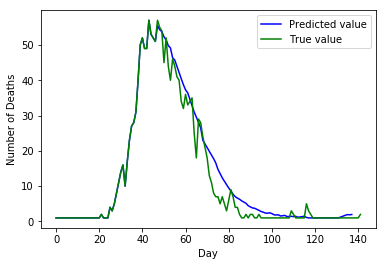

In [26]:
#X = apply_smoothing(X, 6, 'even') 

#tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds.append(y_pred)
    gammas.append(gamma)
    temp_mapes.append(mape(y_te, y_pred))

y_preds = [item for sublist in y_preds for item in sublist]
y_preds_saved = y_preds
y_preds = np.append(y[:tr],y_preds)
print(np.mean(temp_mapes))
plt.plot(y_preds, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

In [25]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

tr1 = 3

X0 = apply_smoothing(X, 19, 'odd')
tr0 = 4

In [14]:
def compute_preds(X, tr):    
    #X = apply_smoothing(X, 6, 'even') 

    #tr = training_poss[np.argmin(loss)]

    N = X.shape[1]
    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    gammas = []
    y_preds = []

    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]


        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
        P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_te@gamma
        y_pred[y_pred < 1] = 1
        y_preds.append(y_pred)
        temp_mapes.append(mae(y_te, y_pred))
        gammas.append(gamma)

    y_preds = [item for sublist in y_preds for item in sublist]
    y_preds_saved = y_preds
    y_preds = np.append(y[:tr],y_preds)
    y_preds = exponential_smoothing(y_preds, 0.65, 7)
    #y_preds = exponential_smoothing(y_preds, 0.9, 7)
    print(np.mean(temp_mapes))
    return y_preds
    #plt.title('Daily number of deaths in France due to the Covid-19')

In [15]:
y_normal = compute_preds(X, tr1)
y_smoothed = compute_preds(X0, tr0)

y_normal = [y_p if y_p > 1 else 1 for y_p in y_normal]
y_smoothed = [y_p if y_p > 1 else 1 for y_p in y_smoothed]

2.068947466021479
2.537639464615661


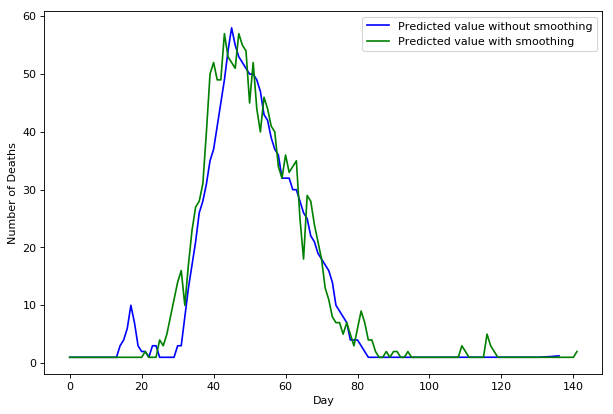

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot('111')
plt.plot(y_smoothed, 'blue', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value without smoothing','Predicted value with smoothing', 'True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

### Without smoothing

In [312]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

In [313]:
training_poss = np.arange(3, 60)
loss = []

for tr in tqdm(training_poss):

    N = X.shape[1]
    splits = int(np.floor((X.shape[0] - tr)/7))

    # list of the mape for a given split, this list is reinitialized for every K
    temp_mapes = []
    y_vals = []
    gammas = []
    y_preds = []

    for i in range(splits):

        begin = 7*i
        end = tr + 7*i

        X_tr = X[begin:end,:]
        y_tr = y[begin:end]

        X_te = X[end:end+7,:]
        y_te = y[end:end+7]


        index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
        P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
        gamma = cvxopt_solve_qp(P, q, G, h)
        y_pred = X_te@gamma
        y_pred[y_pred < 1] = 1
        y_preds.append(y_pred)
        gammas.append(gamma)
        temp_mapes.append(mape(y_te,y_pred))
    
    loss.append(np.mean(temp_mapes))





  0%|          | 0/57 [00:00<?, ?it/s]


  2%|▏         | 1/57 [00:00<00:34,  1.60it/s]


  4%|▎         | 2/57 [00:01<00:38,  1.44it/s]


  5%|▌         | 3/57 [00:02<00:38,  1.41it/s]


  7%|▋         | 4/57 [00:03<00:39,  1.35it/s]


  9%|▉         | 5/57 [00:03<00:39,  1.30it/s]


 11%|█         | 6/57 [00:04<00:41,  1.24it/s]


 12%|█▏        | 7/57 [00:05<00:41,  1.20it/s]


 14%|█▍        | 8/57 [00:06<00:43,  1.14it/s]


 16%|█▌        | 9/57 [00:07<00:46,  1.04it/s]


 18%|█▊        | 10/57 [00:08<00:47,  1.00s/it]


 19%|█▉        | 11/57 [00:09<00:46,  1.02s/it]


 21%|██        | 12/57 [00:11<00:54,  1.22s/it]


 23%|██▎       | 13/57 [00:13<00:55,  1.26s/it]


 25%|██▍       | 14/57 [00:13<00:50,  1.17s/it]


 26%|██▋       | 15/57 [00:15<00:48,  1.16s/it]


 28%|██▊       | 16/57 [00:16<00:50,  1.24s/it]


 30%|██▉       | 17/57 [00:17<00:46,  1.15s/it]


 32%|███▏      | 18/57 [00:18<00:42,  1.08s/it]


 33%|███▎      | 19/57 [00:19<00:38,  1.02s/it]


 35%|███▌      

In [314]:
print('The minimum loss of ', np.min(loss), ' is obtained using ', training_poss[np.argmin(loss)], 'training days') 


The minimum loss of  0.34527455381088057  is obtained using  6 training days


In [7]:
#Number of infected for past two weeks
X = pd.read_csv('data.csv').iloc[:,1:-2].values

#Number of deaths
y = pd.read_csv('data.csv').iloc[:,-2].values

X = apply_smoothing(X, 18, 'even')

tr = 7

0.4854539139453629


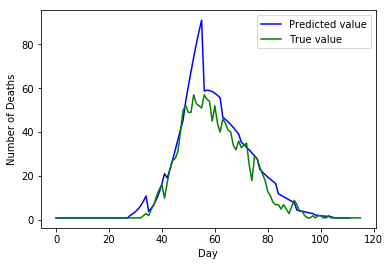

In [9]:
#X = apply_smoothing(X, 6, 'even') 

#tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds_no_smoothing = []
y_preds = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds_no_smoothing.append(y_pred)
    gammas.append(gamma)
    temp_mapes.append(mape(y_te, y_pred))

print(np.mean(temp_mapes))
y_preds_no_smoothing = [item for sublist in y_preds_no_smoothing for item in sublist]
y_preds_saved = y_preds
y_preds_no_smoothing = np.append(y[:tr],y_preds_no_smoothing)
plt.plot(y_preds_no_smoothing, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

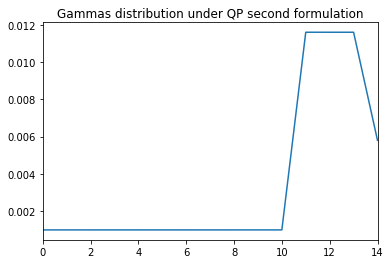

In [16]:
pd.DataFrame(gammas[4]).plot(title='Gammas distribution under QP second formulation', legend=None)

2.029230817357123


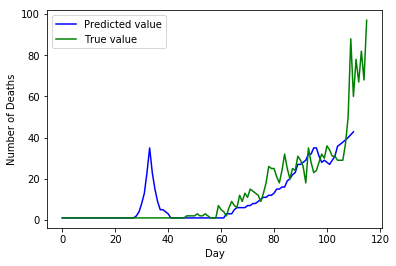

In [332]:
#X = apply_smoothing(X, 6, 'even') 

tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds_no_smoothing = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds_no_smoothing.append(y_pred)
    gammas.append(gamma)
    temp_mapes.append(mape(y_te, y_pred))

print(np.mean(temp_mapes))
y_preds_no_smoothing = [item for sublist in y_preds_no_smoothing for item in sublist]
y_preds_saved = y_preds
y_preds_no_smoothing = np.append(y[:tr],exponential_smoothing(y_preds_no_smoothing,0.65,7))
y_preds_no_smoothing[y_preds_no_smoothing<1] = 1
plt.plot(y_preds_no_smoothing, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

No handles with labels found to put in legend.


(0.19999999999999973, 61.8, 0.14203828882020483, 3.6286789083961497)

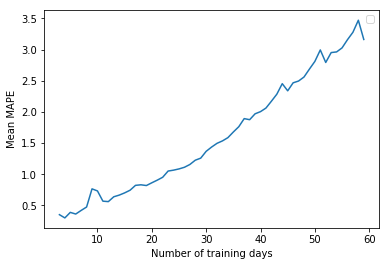

In [287]:
x_data = training_poss
y_data = loss

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_data, y_data)
plt.legend()
#plt.title('Mean MAPE loss based on \n the number of training days')

#ax.plot([0.1, 0.2, 0.3, 0.4], [1, 4, 9, 16])
ax.set_xlabel('Number of training days')
ax.set_ylabel('Mean MAPE')

#plt.axvline(x=tr)
#min_ = 'K= ' + str(tr)
#
#ax.annotate(min_, xy=(tr, min(losses[idx])+2))
ax.axis()

In [288]:
np.min(loss)

0.30052195334638415

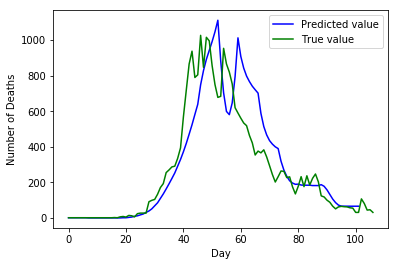

In [290]:
#X = apply_smoothing(X, 6, 'even') 

tr = training_poss[np.argmin(loss)]

N = X.shape[1]
splits = int(np.floor((X.shape[0] - tr)/7))
    
# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
gammas = []
y_preds = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_preds.append(y_pred)
    gammas.append(gamma)

y_preds = [item for sublist in y_preds for item in sublist]
y_preds_saved = y_preds
y_preds = np.append(y[:tr],y_preds)
y_preds = exponential_smoothing(y_preds, 0.65, 7)
plt.plot(y_preds, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

## Quadratic Regularization

In [111]:
X = apply_smoothing(X, 19, 'even') 

In [85]:
N = X.shape[1]

To do:
- Create matrix M
- Create matrix X (DONE)
- Compute X^TX
- Compute M^TM
- Verify M^TM value, if it coincides with the one G.O. wrote in report
- install library, define instances, run optimizer

Apply exponential smoothing on predictions

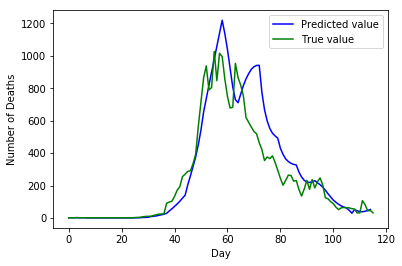

In [212]:
tr = training_poss[np.argmin(loss)]
splits = int(np.floor((X.shape[0] - tr)/7))

# list of the mape for a given split, this list is reinitialized for every K
temp_mapes = []
y_vals = []
y_preds = []
gammas = []

for i in range(splits):
            
    begin = 7*i
    end = tr + 7*i

    X_tr = X[begin:end,:]
    y_tr = y[begin:end]

    X_te = X[end:end+7,:]
    y_te = y[end:end+7]


    index = find_best_index(X_tr, X_te, y_tr, y_te, 'mape', N)
    P, q, G, h = generate_params(X_tr, y_tr, index, N, 10e-15)
    gamma = cvxopt_solve_qp(P, q, G, h)
    gammas.append(gamma)
    y_pred = X_te@gamma
    y_pred[y_pred < 1] = 1
    y_pred = np.ceil(y_pred)
    y_preds.append(y_pred)

y_preds = [item for sublist in y_preds for item in sublist]
y_preds = np.append(y[:tr],y_preds)
y_preds = exponential_smoothing(y_preds, 0.65, 7)

plt.plot(y_preds, 'b', y, 'g')
plt.xlabel('Day')
plt.ylabel('Number of Deaths')
plt.legend(['Predicted value','True value'])
#plt.title('Daily number of deaths in France due to the Covid-19')

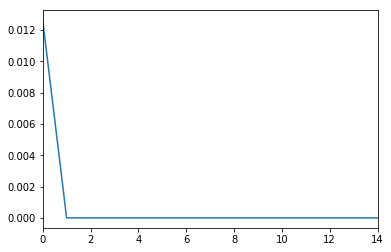

In [899]:
pd.DataFrame(gammas[4]).plot(legend=None)


In [664]:
pd.DataFrame(gammas[0])

,0
0,9.971791e-03
1,9.972672e-03
2,9.972930e-03
3,9.973094e-03
4,9.973321e-03
5,9.973433e-03
6,9.973540e-03
7,9.973648e-03
8,9.973761e-03
9,9.973913e-03


In [605]:
y.shape

(116,)

In [606]:
df = pd.DataFrame({'Actual': y[10:].flatten(), 'Predicted': y_preds[10:].flatten()})
df


ValueError: arrays must all be same length

In [357]:
#index = find_best_index(X_train, X_test, y_train, y_test, 'mape', N)
#P, q, G, h = generate_params(X_train, y_train, index, N)
#gamma = cvxopt_solve_qp(P, q, G, h)
#y_pred = X_test@gamma

In [358]:
#gamma

In [359]:
#pd.DataFrame({'Gammas': gamma}).plot()

In [360]:
#index

In [361]:
#df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#df


In [362]:
#df.plot(kind='bar',figsize=(10,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.show()

In [363]:
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Absolute percentage error:', mape(y_test, y_pred))  
#print('Mean Square percentage error:', mspe(y_test, y_pred))

NameError: name 'y_test' is not defined

## Plot Predictions

In [364]:
def plot_predictions(country,y_test, y_pred):
    y_pred_full = np.append(y[:-7], y_pred)
    plt.plot(y_pred_full, 'g', y, 'b')
    plt.xlabel('Day')
    plt.ylabel('Number of Daily Recovered')
    plt.legend(['Predicted value','True value'])
    plt.title('Prediction of the number of deaths in ' + country + ' using quadratic regularization \n with a MAPE of ' + str(mape(y_test, y_pred))[:5] + ' on the last 7 days of data')
    plt.axvline(x=len(y_pred_full)-17-1)
    plt.axvline(x=len(y_pred_full)-7-1)
    plt.axvline(x=len(y_pred_full))

    text(len(y_pred_full)-17, 5, "train \n set", verticalalignment='center')
    text(len(y_pred_full)-7, 5, "test \n set", verticalalignment='center')

    
    

In [ ]:
plot_predictions('France', y_test, y_pred)

### Find best hyperparameter $\lambda$

In [ ]:
# this is the function we want to minimize
# we want to minimize the mean loss function MAE from our cross validation run
def f(lambda_):
    mapes, maes, y_vals, y_preds = cross_val(splits_X, splits_y, lambda_)
    return np.mean(maes)
    
    
    

In [ ]:
from scipy.optimize import minimize

minimize(f,1.0,method='SLSQP')

In [27]:
from skopt import gp_minimize
from skopt.space import Real, Integer

space  = [Real(10**-5, 10**0, name='learning_rate')]

res = gp_minimize(f,space)
lambda_ = res['x'][0]

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573

 5: -9.9443e+05 -9.8380e+05  3e+03  3e-02  3e-11
 6: -9.6165e+05 -9.6804e+05  8e+03  9e-04  8e-13
 7: -9.6728e+05 -9.6752e+05  2e+02  5e-18  5e-16
 8: -9.6748e+05 -9.6748e+05  4e+00  2e-20  1e-16
 9: -9.6748e+05 -9.6748e+05  4e-02  2e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 2: -1.0003e+06 -1.0003e+06  3e-01  1e-01  1e-10
 3: -9.9986e+05 -9.9733e+05  8e+02  1e-01  1e-10
 4: -9.9584e+05 -9.9498e+05  1e+04  1e-01  1e-10
 5: -9.9859e+05 -9.8834e+05  2e+04  1e-01  1e-10
 6: -9.8919e+05 -9.7442e+05  3e+03  3e-02  3e-11
 7: -9.6351e+05 -9.6664e+05  3e+03  5e-18  9e-16
 8: -9.6652e+05 -9.6655e+05  3e+01  5e-19  2e-16
 9: -9.6655e+05 -9.6655e+05  3e-01  2e-19  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  2e-09
 1: -1.0003e+06 -1.0003e+06  3e-01  2e-01  2e-10
 2: -1.0003e+06 -1.0003

 3: -2.7090e+06 -2.7071e+06  4e+02  6e-02  2e-11
 4: -2.7046e+06 -2.7070e+06  9e+03  6e-02  2e-11
 5: -2.7071e+06 -2.7122e+06  1e+04  6e-02  2e-11
 6: -2.7050e+06 -2.7063e+06  8e+03  3e-02  1e-11
 7: -2.7036e+06 -2.6932e+06  9e+03  3e-02  1e-11
 8: -2.6988e+06 -2.6809e+06  9e+03  2e-02  7e-12
 9: -2.6747e+06 -2.6347e+06  3e+03  8e-03  3e-12
10: -2.6154e+06 -2.6182e+06  3e+03  3e-18  8e-16
11: -2.6179e+06 -2.6181e+06  2e+02  7e-20  1e-16
12: -2.6180e+06 -2.6180e+06  2e+00  9e-19  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0003e+06 -1.0003e+06  5e+00  2e+00  9e-10
 1: -1.0003e+06 -1.0003e+06  3e-01  2e-01  7e-11
 2: -1.0003e+06 -1.0003e+06  3e-01  1e-01  6e-11
 3: -9.9572e+05 -9.9997e+05  9e+03  1e-01  6e-11
 4: -9.9324e+05 -1.0032e+06  2e+04  1e-01  6e-11
 5: -9.9934e+05 -1.0072e+06  4e+04  1e-01  5e-11
 6: -9.9210e+05 -9.8390e+05  5e+04  1e-01  5e-11
 7: -9.8976e+05 -9.8074e+05  9e+02  1e-02  6e-12
 8: -9.7859e+05 -9.6936e+05  8e+03  9e-03  4e-

 6: -2.7066e+06 -2.6842e+06  8e+03  4e-02  3e-11
 7: -2.6763e+06 -2.6301e+06  4e+03  1e-02  1e-11
 8: -2.6092e+06 -2.6123e+06  3e+03  2e-18  4e-16
 9: -2.6122e+06 -2.6123e+06  5e+01  4e-19  1e-16
10: -2.6123e+06 -2.6123e+06  5e-01  9e-19  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7093e+06 -2.7093e+06  4e+00  2e+00  2e-09
 1: -2.7093e+06 -2.7093e+06  2e-01  1e-01  8e-11
 2: -2.7093e+06 -2.7093e+06  2e-01  9e-02  7e-11
 3: -2.7083e+06 -2.7088e+06  2e+03  9e-02  6e-11
 4: -2.7054e+06 -2.6980e+06  1e+04  8e-02  6e-11
 5: -2.7045e+06 -2.6956e+06  9e+03  7e-02  5e-11
 6: -2.7038e+06 -2.6672e+06  2e+04  5e-02  4e-11
 7: -2.6580e+06 -2.6145e+06  3e+03  2e-02  1e-11
 8: -2.6042e+06 -2.6049e+06  7e+02  2e-18  3e-16
 9: -2.6049e+06 -2.6049e+06  7e+00  9e-19  1e-16
10: -2.6049e+06 -2.6049e+06  7e-02  6e-19  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.7093e+06 -2.7093e+06  4e+00  2e+00  2e-09
 1: -2.7093e+06 -2.7093

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 4: -1.0501e+05 -1.0619e+05  2e+03  2e-01  5e-08
 5: -1.0491e+05 -1.0735e+05  6e+03  1e-01  3e-08
 6: -1.0540e+05 -1.0620e+05  8e+02  4e-17  2e-16
 7: -1.0566e+05 -1.0577e+05  1e+02  2e-17  8e-17
 8: -1.0568e+05 -1.0569e+05  9e+00  2e-17  5e-17
 9: -1.0569e+05 -1.0569e+05  1e-01  2e-18  2e-17
10: -1.0569e+05 -1.0569e+05  1e-03  7e-18  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  6e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  1e-17  1e-16
 7: -1.0566e+05 -1.0567e+05  5e+00  1e-17  8e-17
 8: -1.0566e+05 -1.0566e+05  6e-02  2e-17  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6689e+06 -3.6689e+06  5e+00  2e+00  2e-09
 1: -3.6689e+06 -3.6689

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  1e-17  1e-16
 6: -1.0566e+05 -1.0570e+05  4e+01  8e-18  1e-16
 7: -1.0566e+05 -1.0567e+05  5e+00  2e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  2e-17  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6689e+06 -3.6689e+06  5e+00  2e+00  2e-09
 1: -3.6689e+06 -3.6689e+06  4e-01  2e-01  2e-10
 2: -3.6689e+06 -3.6689e+06  3e-01  1e-01  1e-10
 3: -3.6515e+06 -3.6643e+06  3e+04  1e-01  1e-10
 4: -3.6563e+06 -3.6164e+06  8e+04  1e-01  1e-10
 5: -3.6456e+06 -3.5998e+06  5e+04  7e-02  6e-11
 6: -3.6400e+06 -3.5268e+06  1e+05  5e-02  5e-11
 7: -3.5221e+06 -3.4152e+06  1e+04  1e-02  1e-11
 8: -3.3915e+06 -3.3936e+06  2e+03  2e-17  2e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573e+05  2e+02  5e-03  1e-09
 7: -1.0562e+05 -1.0565e+05  3e+01  2e-04  5e-11
 8: -1.0563e+05 -1.0564e+05  7e+00  6e-05  1e-11
 9: -1.0564e+05 -1.0564e+05  9e+00  3e-05  6e-12
10: -1.0564e+05 -1.0564e+05  9e-01  3e-18  1e-16
11: -1.0564e+05 -1.0564e+05  2e-02  5e-18  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  6e-07
 1: -1.0598e+05 -1.0598e+05  7e-01  3e-01  8e-08
 2: -1.0598e+05 -1.0597

 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-17
 7: -1.0566e+05 -1.0567e+05  5e+00  3e-17  1e-16
 8: -1.0566e+05 -1.0566e+05  6e-02  8e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  6e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  7e-01  4e-01  8e-08
 3: -1.0499e+05 -1.0585e+05  1e+03  1e-01  3e-08
 4: -1.0541e+05 -1.0607e+05  2e+03  9e-02  2e-08
 5: -1.0555e+05 -1.0592e+05  5e+02  2e-02  4e-09
 6: -1.0553e+05 -1.0573e+05  2e+02  5e-03  1e-09
 7: -1.0562e+05 -1.0565e+05  3e+01  2e-04  5e-11
 8: -1.0563e+05 -1.0564e+05  7e+00  6e-05  1e-11
 9: -1.0564e+05 -1.0564e+05  9e+00  3e-05  6e-12
10: -1.0564e+05 -1.0564e+05  9e-01  3e-18  1e-16
11: -1.0564e+05 -1.0564e+05  2e-02  5e-18  7e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

 4: -9.9324e+05 -1.0032e+06  2e+04  1e-01  6e-11
 5: -9.9934e+05 -1.0072e+06  4e+04  1e-01  5e-11
 6: -9.9210e+05 -9.8390e+05  5e+04  1e-01  5e-11
 7: -9.8976e+05 -9.8074e+05  9e+02  1e-02  6e-12
 8: -9.7859e+05 -9.6936e+05  8e+03  9e-03  4e-12
 9: -9.8315e+05 -9.7279e+05  1e+04  8e-03  3e-12
10: -9.6780e+05 -9.6879e+05  1e+03  8e-18  1e-15
11: -9.6815e+05 -9.6820e+05  5e+01  9e-19  2e-16
12: -9.6819e+05 -9.6819e+05  5e-01  1e-18  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1

/usr/local/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  2e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  4e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  4e-08
 3: -1.0526e+05 -1.0574e+05  8e+02  2e-01  1e-08
 4: -1.0524e+05 -1.0571e+05  1e+03  1e-01  1e-08
 5: -1.0551e+05 -1.0574e+05  1e+03  1e-01  1e-08
 6: -1.0559e+05 -1.0568e+05  9e+01  2e-17  9e-17
 7: -1.0563e+05 -1.0565e+05  2e+01  5e-18  1e-16
 8: -1.0564e+05 -1.0564e+05  2e+00  4e-18  1e-16
 9: -1.0564e+05 -1.0564e+05  2e-01  7e-18  9e-17
10: -1.0564e+05 -1.0564e+05  7e-03  1e-18  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0598e+05 -1.0598e+05  5e+00  2e+00  5e-07
 1: -1.0598e+05 -1.0598e+05  9e-01  4e-01  9e-08
 2: -1.0598e+05 -1.0597e+05  8e-01  4e-01  9e-08
 3: -1.0503e+05 -1.0583e+05  1e+03  1e-01  2e-08
 4: -1.0567e+05 -1.0603e+05  1e+03  8e-02  2e-08
 5: -1.0563e+05 -1.0582e+05  2e+02  2e-17  7e-17
 6: -1.0566e+05 -1.0570e+05  4e+01  2e-18  8e-1